# Capstone2 Modeling Mental Health Dataset

## Table of Contents
- [1. Overview](#1.-Overview)
- [2. Import Libraries](#2.-Import-Libraries)
- [3. Load Data](#3.-Load-Data)
- [4. Analyze Data](#4.-Analyze-Data)
- [5. Preparing the Data](#5.-Preparing-the-Data)
- [6. Modeling](#6.-Modeling)
    - [6.1 Global Model](#6.1-Global-Model)
        -  [6.1.1 Logistic Regression](#6.1.1-Logistic-Regression)
        -  [6.1.2 Random Forest](#6.1.2-Random-Forest)
        -  [6.1.3 LightGBM](#6.1.3-LightGBM)
        -  [6.1.4 XGBoost](#6.1.4-XGBoost)
        -  [6.1.5 Check for model overfitting K-fold Cross-Validation](6.1.6-Check-for-model-overfitting-K---fold-Cross---Validation)
        -  [6.1.6 Top 10 Features Influencing Model Prediction](#6.1.6-Top-10-Features-InfluencingModel-Prediction)
        -  [6.1.7 Trade-off Analysis: True Positives and False Negatives at Different Thresholds](#6.1.7-Trade---off-Analysis:-True-Positives-and-False-Negatives-at-Different-Thresholds)
    - [6.2 Country Models](#6.2-Segmented-Country-Models)
        - [6.2.1 Evaluating Performance using LogisticRegression](#6.2.1-Evaluating-Performance-using-LogisticRegression)
        - [6.2.2 Review](#6.2.2-Review)
- [7. Summary](#7.-Summary)

## 1. Overview

The focus of the mental health modeling project is to develop a predictive model that identifies individuals likely to need mental health support. This analysis is based on a comprehensive dataset of categorical features, encompassing over 290,000 observations. Key factors considered in the model include demographics, mental health conditions, sentiment analysis scores, and psychological indicators.

The project builds upon prior analysis and base modeling using logistic regression for both the global and segmented models. The results include an accuracy of 0.69 on the global model with a 0.76 AUC, and for the high-performance segment, accuracy of 0.69 and 0.73 AUC. The lower-performing segment showed 0.54 Accuracy and 0.55 AUC.

In the modeling phase, we will implement XGBoost, LightGBM, and Random Forest algorithms, focusing on fine-tuning hyperparameter settings to enhance performance. We will also explore stacking approach to combine the models for better results. We will also create separate models for the high and low segments to address their specific needs and assess how these can be integrated with the global model to improve prediction performance.

To ensure the reliability of our models, we will expand our evaluation metrics beyond accuracy and AUC, and include cross-validation using weighted F1 for the scoring. We will also apply k-fold cross-validation to test the model for overfitting.

## 2. Import Libraries

In [4]:
%load_ext autoreload

In [7]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import os, sys
%autoreload 2
# Import 'libs' directory
libs_path = os.path.join(os.getcwd(), '../libs')
sys.path.append(libs_path)
import data_utils as utils

# Common runtime settings
utils.random_state=42
utils.verbose=1

## 3. Load Data

In [9]:
mh_df = pd.read_csv('../data/MentalHealthDataset.csv')

## 4. Analyze Data

In [10]:
mh_df.head()

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


## 5. Preparing the Data

#### Resolving Duplicates

But first, we need to deal with 'Timestamp'. Dropping the column outright causes 78% of the observations to be duplicated. We need to create new features out of the timestamp components to retain uniqueness among the rows. 

The new feature may enhance the model's ability to capture temporal patterns and improve performance.

In [51]:
df = mh_df.copy()
# Pre-check - count duplicates with 'Timestamp' as index.
print(f'Duplicates before dropping "Timestamp": {df.duplicated().sum()}')

# Load data using our MentalHealthData processing object.
# The first step in the process is to drop the 'Timestamp' Column.
# 
mh_o = utils.MentalHealthData(df)
mh_o.train_test_split() # Split with default target 'treatment'

print(f'Duplicates after dropping "Timestamp": {mh_o.X_train.duplicated().sum()}')
print(f'\nX_train: {mh_o.X_train.shape}, x_test: {mh_o.x_test.shape}')
print(f'y_train: {mh_o.y_train.shape}, y_test: {mh_o.y_test.shape}')
print(f'y: {mh_o.y.shape}')

Duplicates before dropping "Timestamp": 2307
Duplicates after dropping "Timestamp": 206329

X_train: (261596, 41), x_test: (15470, 41)
y_train: (261596,), y_test: (15470,)
y: (277066,)


In [52]:
# Make sure test and train columns match
mh_o.X_train.columns.difference(mh_o.x_test.columns)

Index([], dtype='object')

As seen in the output, duplicates went from **2313** to **208718** after dropping **'Timestamp'**.
Reducing the number of unique observations to **83646** out of the **292364** total observations in the dataset.

To keep the uniqueness of most of the observation we will create new features from 'Timestamp' as **'year'**, 
**'month'**, **'day'**, **'hour'**, and **'min'**. 

We will drop 'Timestamp' after creating the new features.


The next step will update and create the new features and apply transformations to our data.

Now we're ready to apply additional pre-processing and onto modeling

In [53]:
# Now were ready to apply pre-processing and modeling
print(f'Duplicates before dropping "Timestamp": {mh_df.duplicated().sum()}')
# Run feature transformation, feature engineering
mh_o = utils.mental_health_instance(mh_df.copy())

print(f'Duplicates after dropping "Timestamp": {mh_o.X_train.duplicated().sum()}')
print(f'\nX_train: {mh_o.X_train.shape}, x_test: {mh_o.x_test.shape}')
print(f'y_train: {mh_o.y_train.shape}, y_test: {mh_o.y_test.shape}')
print(f'y: {mh_o.y.shape}')


Duplicates before dropping "Timestamp": 2307
Duplicates after dropping "Timestamp": 2517

X_train: (195330, 46), x_test: (81736, 46)
y_train: (195330,), y_test: (81736,)
y: (277066,)


Observe that we have more unique observations than duplicates after applying the changes.

We also retained the duplicates and took special care to keep them out of the test data set during pre-processing.

In [54]:
mh_o.get_data().head()

,family_history,treatment,Coping_Struggles,year,month,day,hour,minute,Gender_Male,Country_Brazil,...,Mood_Swings_Low,Mood_Swings_Medium,Work_Interest_No,Work_Interest_Yes,Social_Weakness_No,Social_Weakness_Yes,mental_health_interview_No,mental_health_interview_Yes,care_options_Not_sure,care_options_Yes
0,0,1,0,2014,8,27,11,29,0,0,...,0,1,1,0,0,1,1,0,1,0
1,1,1,0,2014,8,27,11,31,0,0,...,0,1,1,0,0,1,1,0,0,0
2,1,1,0,2014,8,27,11,32,0,0,...,0,1,1,0,0,1,1,0,0,1
3,1,1,0,2014,8,27,11,37,0,0,...,0,1,1,0,0,1,0,0,0,1
4,1,1,0,2014,8,27,11,43,0,0,...,0,1,1,0,0,1,1,0,0,1


In [55]:
# Check stats
mh_o.X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195330 entries, 20530 to 291985
Data columns (total 46 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   family_history                   195330 non-null  int64
 1   Coping_Struggles                 195330 non-null  int64
 2   year                             195330 non-null  int64
 3   month                            195330 non-null  int64
 4   day                              195330 non-null  int64
 5   hour                             195330 non-null  int64
 6   minute                           195330 non-null  int64
 7   Gender_Male                      195330 non-null  int64
 8   Country_Brazil                   195330 non-null  int64
 9   Country_Canada                   195330 non-null  int64
 10  Country_Germany                  195330 non-null  int64
 11  Country_India                    195330 non-null  int64
 12  Country_Ireland                

In [56]:
mh_df.head()

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


In [57]:
# Get Cramer's V
# TODO: sort and show high correlations only.

cramers_v_df = utils.ordinal_cramers_v_matrix(mh_df)
cramers_v_df

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
Timestamp,1.000000,0.897598,0.925771,0.022381,0.904235,0.893134,0.890679,0.014096,0.037860,0.008057,0.024742,0.015375,0.051310,0.014274,0.008451,0.896209,0.888375
Gender,0.897598,0.999988,0.130081,0.049869,0.059358,0.199517,0.166121,0.031409,0.059650,0.012695,0.038982,0.024225,0.057154,0.022489,0.013316,0.131208,0.109220
Country,0.925771,0.130081,1.000000,0.003243,0.227042,0.144728,0.116068,0.002043,0.005487,0.001168,0.003586,0.002228,0.007436,0.002069,0.001225,0.170563,0.208895
Occupation,0.022381,0.049869,0.003243,1.000000,0.002953,0.009950,0.008285,0.069469,0.076980,0.065248,0.074696,0.133881,0.079471,0.056516,0.075410,0.004627,0.003851
self_employed,0.904235,0.059358,0.227042,0.002953,0.999979,0.000709,0.022207,0.001860,0.003533,0.000752,0.002309,0.001435,0.003373,0.001332,0.000789,0.049810,0.059165
family_history,0.893134,0.199517,0.144728,0.009950,0.000709,0.999993,0.359179,0.006267,0.011902,0.002533,0.007778,0.004833,0.011398,0.004487,0.002657,0.079560,0.137960
treatment,0.890679,0.166121,0.116068,0.008285,0.022207,0.359179,0.999993,0.005218,0.009910,0.002109,0.006476,0.004024,0.009489,0.003736,0.002212,0.107525,0.291815
Days_Indoors,0.014096,0.031409,0.002043,0.069469,0.001860,0.006267,0.005218,1.000000,0.058666,0.089346,0.096451,0.077621,0.091822,0.060785,0.093140,0.002914,0.002426
Growing_Stress,0.037860,0.059650,0.005487,0.076980,0.003533,0.011902,0.009910,0.058666,1.000000,0.065104,0.022716,0.047677,0.039782,0.076603,0.029749,0.005534,0.004607
Changes_Habits,0.008057,0.012695,0.001168,0.065248,0.000752,0.002533,0.002109,0.089346,0.065104,1.000000,0.067751,0.063298,0.051409,0.045817,0.045347,0.001178,0.000980


Timestamp is too correlated with other features. We are going to drop timestamp later and create features from it.

In [58]:
mh_interim = mh_df.copy()
utils.pre_process_timestamp(mh_interim)
mh_interim.drop(columns='Timestamp', inplace=True)
mh_interim

,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,...,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options,year,month,day,hour,minute
0,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,...,No,No,Yes,No,Not sure,2014,8,27,11,29
1,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,...,No,No,Yes,No,No,2014,8,27,11,31
2,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,...,No,No,Yes,No,Yes,2014,8,27,11,32
3,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,...,No,No,Yes,Maybe,Yes,2014,8,27,11,37
4,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,...,No,No,Yes,No,Yes,2014,8,27,11,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292359,Male,United States,Business,Yes,Yes,Yes,15-30 days,No,Maybe,No,...,Yes,No,Maybe,Maybe,Not sure,2015,7,27,23,25
292360,Male,South Africa,Business,No,Yes,Yes,15-30 days,No,Maybe,No,...,Yes,No,Maybe,No,Yes,2015,8,17,9,38
292361,Male,United States,Business,No,Yes,No,15-30 days,No,Maybe,No,...,Yes,No,Maybe,No,No,2015,8,25,19,59
292362,Male,United States,Business,No,Yes,Yes,15-30 days,No,Maybe,No,...,Yes,No,Maybe,No,Yes,2015,9,26,1,7


Run Cramer's V once again without the Timestamp

In [59]:
# fillna with value 'Unknown' 
df = mh_interim.copy()
df['self_employed'] = df['self_employed'].fillna('Unknown')

# convert 'Yes', 'No' to 1, 0 - Coping_Struggles, family_history, treatment
for col in df:
    if len(df[col].unique()) == 2 and col != 'Gender':
        df[col] = df[col].apply(lambda x: {'Yes': 1, 'No': 2}.get(x, x))

# one-hot encode
categorical_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_encoded.columns = df_encoded.columns.str.replace(' ', '_') 

df_encoded.astype(int)

cramers_v_df = utils.ordinal_cramers_v_matrix(df_encoded)
cramers_v_df

,family_history,treatment,Coping_Struggles,year,month,day,hour,minute,Gender_Male,Country_Brazil,...,Mood_Swings_Low,Mood_Swings_Medium,Work_Interest_No,Work_Interest_Yes,Social_Weakness_No,Social_Weakness_Yes,mental_health_interview_No,mental_health_interview_Yes,care_options_Not_sure,care_options_Yes
family_history,0.999993,0.359179,0.011398,0.050104,0.106880,0.205528,0.217762,0.257246,0.199517,0.014080,...,0.001925,0.002757,0.001863,0.004466,0.002061,0.000469,0.077375,0.044251,0.085430,0.134527
treatment,0.359179,0.999993,0.009489,0.085111,0.119611,0.173250,0.209069,0.376635,0.166121,0.035221,...,0.001601,0.002294,0.001550,0.003718,0.001715,0.000389,0.101162,0.001076,0.148191,0.290675
Coping_Struggles,0.011398,0.009489,0.999993,0.001095,0.007278,0.009540,0.011623,0.018797,0.057154,0.002486,...,0.029607,0.038985,0.044765,0.013306,0.007311,0.022315,0.007437,0.003413,0.002481,0.004091
year,0.050104,0.085111,0.001095,1.000000,0.677673,0.730593,0.357268,0.297581,0.019160,0.051885,...,0.000186,0.000265,0.000180,0.000430,0.000199,0.000046,0.033641,0.006571,0.028336,0.079066
month,0.106880,0.119611,0.007278,0.677673,1.000000,0.804479,0.269345,0.302563,0.127315,0.067235,...,0.001233,0.001764,0.001193,0.002855,0.001320,0.000304,0.105412,0.025003,0.109681,0.106279
day,0.205528,0.173250,0.009540,0.730593,0.804479,1.000000,0.284691,0.288308,0.166885,0.084080,...,0.001616,0.002312,0.001564,0.003742,0.001730,0.000399,0.165913,0.251306,0.146735,0.179499
hour,0.217762,0.209069,0.011623,0.357268,0.269345,0.284691,1.000000,0.299228,0.203321,0.173373,...,0.001969,0.002817,0.001906,0.004560,0.002108,0.000486,0.233121,0.136363,0.177575,0.243108
minute,0.257246,0.376635,0.018797,0.297581,0.302563,0.288308,0.299228,1.000000,0.328822,0.311629,...,0.003185,0.004556,0.003082,0.007374,0.003409,0.000786,0.289330,0.250423,0.287768,0.304322
Gender_Male,0.199517,0.166121,0.057154,0.019160,0.127315,0.166885,0.203321,0.328822,0.999988,0.044125,...,0.009675,0.013847,0.009365,0.022415,0.010359,0.002381,0.130254,0.060055,0.043541,0.071687
Country_Brazil,0.014080,0.035221,0.002486,0.051885,0.067235,0.084080,0.173373,0.311629,0.044125,0.999785,...,0.000386,0.000571,0.000373,0.000947,0.000416,0.000063,0.030247,0.016036,0.056156,0.000067


Run Cramer's V on features correlation to target.

In [60]:
target = 'treatment'

# Get feature correlations relative to the target
corr_df = utils.cramers_v_corr_to_target(mh_interim, target) \
  .sort_values(by='CV', ascending=False)

corr_df.head(3)

,Feature,CV
19,minute,0.376635
4,family_history,0.359179
14,care_options,0.291815


## 6. Modeling

A custom library was developed to separate code-intensive operations and emphasize the presentation of the modeling strategy in this notebook. In the following sections, we will utilize **libs/data_utils.py** to perform the necessary steps to train and evaluate the performance of four pre-selected models:

- Logistic Regresssion
- LightGBM
- XGBoost
- Random Forest

Strategy for Each Model:

- Evaluate the optimized precision and recall thresholds to identify the balanced threshold using the F1 score.
- Get the optimized hyper-parameter values for each classifier using Bayesian Optimization.
- Train the models using the best parameter values obtained in the previous step.
- Use the top-performing models from LightGBM, XGBoost, and Random Forest as base models for a StackingClassifier.
- Train the StackingClassifier with Logistic Regression as the final learner.
- Record and assess the performance metrics for each model.

### 6.1 Global Model

**Evaluating the Precision/Recall Optimal Threshold**

In each evaluated model we specify a balanced class weights as well as specify F1 score as the metric to identify the optimized precision and recall, as well as the optimal threshold value.

For mental health treatment prediction, **recall** is important to correctly predict if a patient needs help. Missing someone who needs treatment can be problematic. We want to make sure the model finds all the right people.

The **F1 score** balances between catching everyone who needs treatment while avoiding too many false alarms. It's useful when we care about both finding the right people and not over-predicting.

**Trade-offs:**
By analyzing the evaluation results (recall, precision, F1 score), the stake holders can decide which trade-offs make sense for a specific use case.

#### 6.1.1 Logistic Regression


/Users/judesantos/miniconda3/envs/mlenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
[[21407 17679]
 [ 6610 36040]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.55      0.64     39086
           1       0.67      0.85      0.75     42650

    accuracy                           0.70     81736
   macro avg       0.72      0.70      0.69     81736
weighted avg       0.72      0.70      0.70     81736


Log loss: 10.711
Optimal Threshold: 0.321


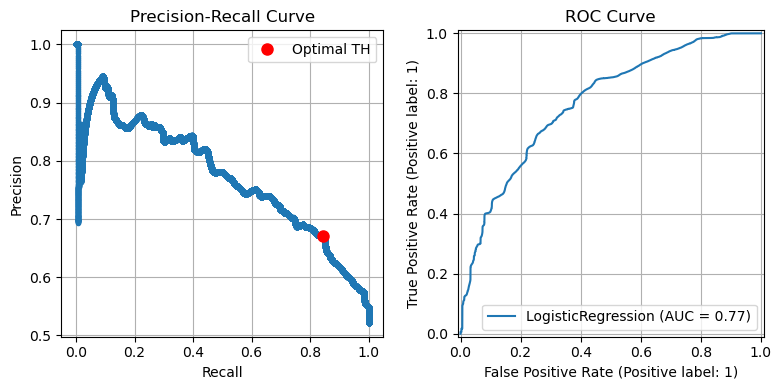

In [61]:
def get_LR_model():
  return LogisticRegression(class_weight='balanced', max_iter=1600, n_jobs=-1, random_state=utils.random_state)

_ = utils.evaluate_precision_recall_optimized_model(mh_o, get_LR_model, metric='f1')

#### 6.1.2 Random Forest

Confusion Matrix:
[[38321   765]
 [ 1155 41495]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     39086
           1       0.98      0.97      0.98     42650

    accuracy                           0.98     81736
   macro avg       0.98      0.98      0.98     81736
weighted avg       0.98      0.98      0.98     81736


Log loss: 0.847
Optimal Threshold: 0.491


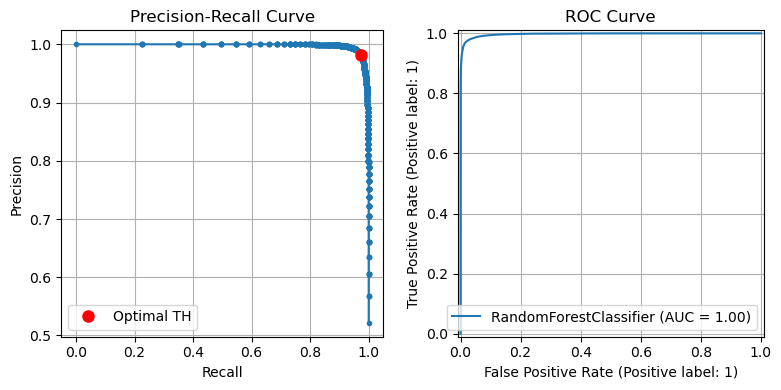

In [62]:
# Evaluate RandomForest model
def get_RF_model():
  return RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=utils.random_state)

_ = utils.evaluate_precision_recall_optimized_model(mh_o, get_RF_model, metric='f1')

#### 6.1.3 LightGBM

Confusion Matrix:
[[38715   371]
 [  341 42309]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     39086
           1       0.99      0.99      0.99     42650

    accuracy                           0.99     81736
   macro avg       0.99      0.99      0.99     81736
weighted avg       0.99      0.99      0.99     81736


Log loss: 0.314
Optimal Threshold: 0.397


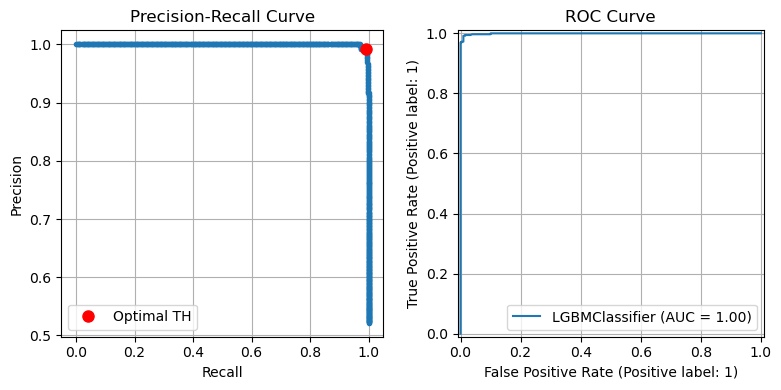

In [63]:
# Evaluate LGBM
def get_LGBM_model():
  return LGBMClassifier(class_weight='balanced', n_jobs=-1, random_state=utils.random_state, verbose=0)

_ = utils.evaluate_precision_recall_optimized_model(mh_o, get_LGBM_model, metric='f1')

#### 6.1.4 XGBoost

Confusion Matrix:
[[39086     0]
 [  108 42542]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39086
           1       1.00      1.00      1.00     42650

    accuracy                           1.00     81736
   macro avg       1.00      1.00      1.00     81736
weighted avg       1.00      1.00      1.00     81736


Log loss: 0.048
Optimal Threshold: 0.685


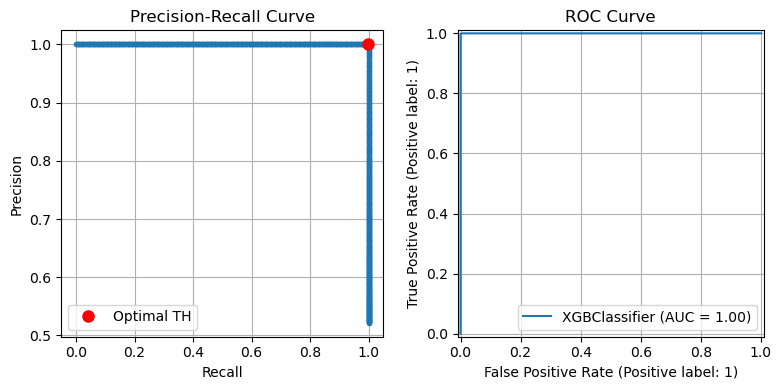

In [64]:
# Evaluate XGB
def get_XGB_model():
  #scale_pos_weight = sum(mh_o.y_train == 0) / sum(mh_o.y_train == 1)
  #return XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=-1, random_state=utils.random_state)
  return XGBClassifier(n_jobs=-1, random_state=utils.random_state)

fitted_model = utils.evaluate_precision_recall_optimized_model(mh_o, get_XGB_model, metric='f1')

The predictive performance of the XGBoost, LightGBM, and Random Forest models is strong, and no further optimization is needed. XGBoost is the best model for recall optimization, with key findings:

- No false negatives and 116 false positives, indicating excellent recall.
- Log loss is 0.048, the lowest among models, showing high confidence in predictions.
- Optimal threshold is 0.430.
- Both precision and recall for class 1 are at 100%, meaning the model is highly accurate in identifying true positives.
- Overall accuracy is 100%.

#### 6.1.5 Check for model overfitting

**Using K-fold Cross-Validation**

In [65]:
# Get intance of prepared data and X, y splits
mh = utils.mental_health_instance(mh_df.copy())
# Define the model, parameters
scale_pos_weight = sum(mh.y == 0) / sum(mh.y == 1)
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=-1, random_state=utils.random_state)
# Run 15 k-fold tests. 
# Cross validate each folds performance on the train and test data.
# Output the scores and see if anything is worth noticing.
utils.kfold_model_cross_validation(mh, xgb_model, 30)

Train data CV scores: [0.99811567 0.99781309 0.99854524 0.99840232 0.99867511 0.99897225
 0.99896526 0.99852071 0.99852507 0.99926156 0.99897466 0.99795322
 0.99763593 0.99898359 0.99867354 0.99881023 0.99841017 0.99866884
 0.99798155 0.99768986 0.99808739 0.99810578 0.99765258 0.99841977
 0.99882938 0.99898536 0.99911243 0.99869205 0.99912049 0.9976422 ]
Train data Mean CV score: 0.9985
Train data CV scores std: 0.0005

Test data CV scores: [0.99821747 0.9993146  0.9979564  0.99892895 0.99861878 0.99861974
 0.99929078 0.99860918 0.99895725 0.99892512 0.99928418 0.99789326
 0.99826208 0.99964476 0.99926901 0.99857854 0.9982681  0.99716312
 0.99820079 0.99646143 0.99788285 0.9989673  0.99928469 0.99896872
 0.99859748 0.99890391 1.         0.99964998 0.99893124 0.99859944]
Test data Mean CV score: 0.9987
Test data CV scores std: 0.0007


##### Using Bootstrap

In [66]:
# Use previously prepared model and MH data instance for this test.

# Run 15 k-fold tests in 30 bootstraps. 
# Cross validate each folds performance on the train and test data.
# Output the scores and see if anything is worth noticing.
utils.bootstrap_model_cross_validation(mh, xgb_model, 15, 15)

Mean Cross-Validation Scores: [0.99869577 0.99877532 0.99852023 0.99873576 0.99857346 0.99856412
 0.99848089 0.99866226 0.99861561 0.99864041 0.99852407 0.99853062
 0.9986445  0.99846861 0.99872044]
Mean Overall Cross-Validation Score: 0.9986
95% Confidence Interval: [0.99778267 0.9990766 ]


The XGBoost model performance is consistent across different folds and is not overfitting.

This suggests XGBoost is performing exceptionally well, especially for identifying all individuals who need treatment.

#### 6.1.6 Top 5 Features with Strong Positive and Negative Influence on Model Prediction 

In [ ]:
shap_df = utils.top_model_influencers(fitted_model, mh_o.x_test, n_influencers=5)
shap_df.style.hide(axis='index')

Feature,Score
care_options_Yes,0.049648
family_history,0.030055
Gender_Male,0.021771
Country_Canada,0.008508
Country_New_Zealand,0.007661
Country_Italy,-0.009489
Country_Israel,-0.012308
self_employed_Yes,-0.012440
Country_France,-0.014492
mental_health_interview_No,-0.043055


#### 6.1.7 Trade-off Analysis: True Positives and False Negatives at Different Thresholds

In [ ]:
trade_offs = utils.analyze_tradeoffs(mh_o, get_XGB_model)
trade_offs.style.hide(axis='index')

Threshold,Precision,Recall,True Positives,False Negatives
0.429932,0.997,1.000,43337,0
0.471660,0.997,0.997,43217,120
0.498848,1.000,0.994,43096,241
0.577143,1.000,0.992,42977,360
0.657853,1.000,0.989,42851,486
0.681693,1.000,0.986,42718,619
0.701262,1.000,0.983,42598,739
0.706736,1.000,0.980,42479,858
0.709127,1.000,0.977,42357,980
0.803280,1.000,0.975,42240,1097


### 6.2 Country Models

#### 6.2.1 Evaluating Performance using XGBoost 

The following steps required the proper segregation of country specific data:
- Create a country specific subset from the mental health dataset using:

  ```
    df_country = df[df['Country'] == country_name]
  ```

- Pre-process data: Transform, feature-engineering
- Train/test split country data.
- Run predictions
- Get values:
  - Accuracy
  - AUC
  - Cross-Validation mean and std score (scoring used is weighted F1, cv=5)

In [40]:
# Train/evaluate models
report_df = utils.evaluate_by_feature_country(mh_df.copy(), get_XGB_model)

In [41]:
report_df.style.hide(axis='index')

Country,Accuracy,AUC,CV-F1 (mean),CV-F1 (std),Other
United States,0.998,1.000,0.993,0.009,
Poland,,,,,One class found: [No]. >1 class is required for modeling.
Australia,1.000,1.000,1.000,0.000,
Canada,1.000,1.000,1.000,0.000,
United Kingdom,1.000,1.000,1.000,0.000,
South Africa,1.000,1.000,1.000,0.000,
Sweden,1.000,1.000,1.000,0.000,
New Zealand,1.000,1.000,1.000,0.000,
Netherlands,1.000,1.000,1.000,0.000,
India,1.000,1.000,1.000,0.000,


#### Test the global model on a subset without the countries having a single category target class.

In [47]:
exclude_countries = []

for idx, row in report_df.iterrows():
  if 'One class found' in row['Other']:
    exclude_countries.append(row['Country'])

exclude_countries

['Poland',
 'Belgium',
 'France',
 'Portugal',
 'Costa Rica',
 'Russia',
 'Finland',
 'Israel',
 'Italy',
 'Bosnia and Herzegovina',
 'Singapore',
 'Nigeria',
 'Croatia',
 'Thailand',
 'Denmark',
 'Mexico',
 'Greece',
 'Moldova',
 'Colombia',
 'Georgia',
 'Czech Republic',
 'Philippines']

In [50]:
mh_df = mh_df[~mh_df['Country'].isin(exclude_countries)]
mh_df['Country'].value_counts()

Country
United States     171308
United Kingdom     51404
Canada             18726
Australia           6026
Netherlands         5894
Ireland             5548
Germany             4680
Sweden              2818
India               2774
Brazil              2340
South Africa        1994
New Zealand         1994
Switzerland         1560
Name: count, dtype: int64

The predictive ability of the model has not diminished - with all parameters being the same, while excluding all data points by country with a single class target. 

The model has been proven in various ways to be very effective at predicting treatment support.

#### 6.2.2 Review

- The countries like the US and the UK show excellent performance. Countries like Australia, South Africa, and others achieved perfect scores.

- **One-Class Issue:** Several countries, including Poland, Belgium, and France, are with only one class being present in the dataset. This prevents meaningful modeling. This indicates a potential data imbalance, or a lack of diverse cases in those regions.

- **Requires Further Analysis:** Countries with perfect scores needs a closer examination of the dataset to understand if the models are overly fitted or if the data truly represents a distinct population without variability.

- **Next Steps:** Consider enhancing datasets for countries facing the one-class issue to include more diverse cases.

## 7. Summary

The objective of this notebook is to model and predict the likelihood of an individual to need mental health support based on several demographic and mental health factors.

The observations from the country models may have significant effect on the global model, in terms of performance, and feature selection. 

Considerations:

- The single-class problem in some countries need consideration of data representation in the global model. If a large portion of the dataset is not balanced, the global model may poorly predict results across countries.
- The global model is a single architecture, consider making it more modular to accommodate different countries. For this, using ensemble methods to combine outputs from country-specific models may enhance the overall performance.
- Incorporate new data, features, methods. The new information may enhance model accuracy over time.
Unique patterns may be found from the country analysis, explore using a hybrid model and the global model serving as a baseline and country models are used to tune predictions.


The knowledge gained from country-specific modeling should be the main factor to refine the global model. By studying the unique features of different regions, the global model can be made robust and effective across different contexts. 

The need for continuous evaluaton and adaption based on these observations will be necessary to ensuring continued improvement in predicting the need for mental health support.